## 0. What is transfer learning?

It involves taking parameters of what one model has learned on another dataset and applying to our dataset

* Pretrained model = foundation model

In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.6.0+cu124
0.21.0+cu124


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Total 4393 (delta 0), reused 0 (delta 0), pack-reused 4393 (from 1)
Receiving objects: 100% (4393/4393), 764.14 MiB | 44.20 MiB/s, done.
Resolving deltas: 100% (2656/2656), done.
Updating files: 100% (248/248), done.


In [3]:
# Setup device agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get some data

still using the pizza, steak and sushi data

In [4]:
import os
import zipfile

from pathlib import Path

import requests

# Setup data path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi" # image from subset of classes from the

# If the image folder doesnt exist, download it and prepare it
if image_path.is_dir():
  print(f"Already exist")
else:
  print(f"Didn't find it, downloading now ...")
  image_path.mkdir(parents = True, exist_ok = True)

  # Download the data
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading data ...")
    f.write(request.content)

    # Unzip the data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
      print("Unzipping pizza, steak, sushi")
      zip_ref.extractall(image_path)
      print("Done !")

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

Didn't find it, downloading now ...
Unzipping pizza, steak, sushi
Done !


In [5]:
# Setup directory path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [6]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

## 2. Create datasets and DataLoaders

We have done get some data, next turn it to datasets and dataloader

We can use the going_modular.py file

What we need to think when loading: how to **transform** it?
and with 'torchvision' there are 2 ways:
1. Manually created transforms - you defince what transforms you want your data to go through
2. Automatically created transforms - the transforms for your data are defined by the model you'd like to use

**IMPORTANT**
When using pretrained model, its importan that the data (include custom data) that you pass through fix **transformed** in the same way that the data the model trained on

In [7]:
from going_modular.going_modular import data_setup


### 2.1 Creating a transform for 'torchvision.models' (manual)

trochvision.model contains pretrained model (model ready for transfer learning) right within torchvision

In [8]:
from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
    transforms.Resize((224,224)), # Resize image to 224 by 244
    transforms.ToTensor(), # Get image into range 0 -> 1
    normalize # Make sure images havet the same distribution as ImageNet
])



In [9]:
from going_modular.going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = manual_transforms,
                                                                               batch_size = 32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7ac3d1887e50>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for 'torchvision.model' (auto)



In [10]:
import torchvision

In [11]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # Default = best performing
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [12]:
# Get the transforms used to create out pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [13]:
# Craete DataLoaders using automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = auto_transforms,
                                                                               batch_size = 32)
train_dataloader, test_dataloader, class_names



(<torch.utils.data.dataloader.DataLoader at 0x7ac3d1834e50>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

Various places to get pretrained model,:
1. Pytorch domain libraries
2. Libraries like 'timm' (torch image model)
3. HuggingFace Hub
4. Paperswithcode

### 3.1 Which pretrained model should you use?

The whole idea of transfer learning: take an already well-performing model from a proble space similar to my own and then customize it

3 things to consider:
1. Speed - how fast does it run?
2. Size - how big is the model?
3. Performance - how well does it go on your chosen proble (e.g. how ell does it classify food images)

Where does the model stored on hardware?
- car?
- server?

### 3.2 Setting up a pretrained model

This time is EfficientnetB0

In [14]:
# Create a pretrained model\
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 108MB/s] 


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### 3.3 Getting a summary of our model with torchinfo.summary



In [15]:
# Print with torchinfo
from torchinfo import summary

summary(model = model,
        input_size = (1,3,224,224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Freezing the base model and changing the output layer to suit out needs

With a feature extractor model, typically we will freeze the base layers of pretrained/foundation model and updatethe output layer

In [16]:
# Freeze all of the base layer of EffB0
for param in model.features.parameters():
  param.requires_grad = False

In [17]:
# Update the classifier head to suit our own problem
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features = 1280, # Feature vector coming in, check the number before the sequential (classifier)
              out_features = len(class_names)) # how many classes do we have
).to(device)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [18]:
summary(model = model,
        input_size = (1,3,224,224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4. Train model

In [19]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

In [20]:
# Import train function
from going_modular.going_modular import engine

# Set the manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

#Setup training and save the results
results = engine.train(model = model,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs = 10,
                       device = device)

# End the timer and print out how long it took
end_timer = timer()
print(f"[INFO] Total training time: {end_timer-start_time} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7912 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6373 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561
Epoch: 6 | train_loss: 0.5785 | train_acc: 0.8945 | test_loss: 0.5743 | test_acc: 0.8759
Epoch: 7 | train_loss: 0.5263 | train_acc: 0.9102 | test_loss: 0.5470 | test_acc: 0.8759
Epoch: 8 | train_loss: 0.5226 | train_acc: 0.8008 | test_loss: 0.5291 | test_acc: 0.8665
Epoch: 9 | train_loss: 0.5671 | train_acc: 0.8125 | test_loss: 0.5076 | test_acc: 0.8456
Epoch: 10 | train_loss: 0.4847 | train_acc: 0.8203 | test_loss: 0.4400 | test_acc: 0.9062
[INFO] Total training time: 28.759247668 seconds


## 5. Evaluate model by making loss curve

Couldn't find helper_functions.py, downloading it...


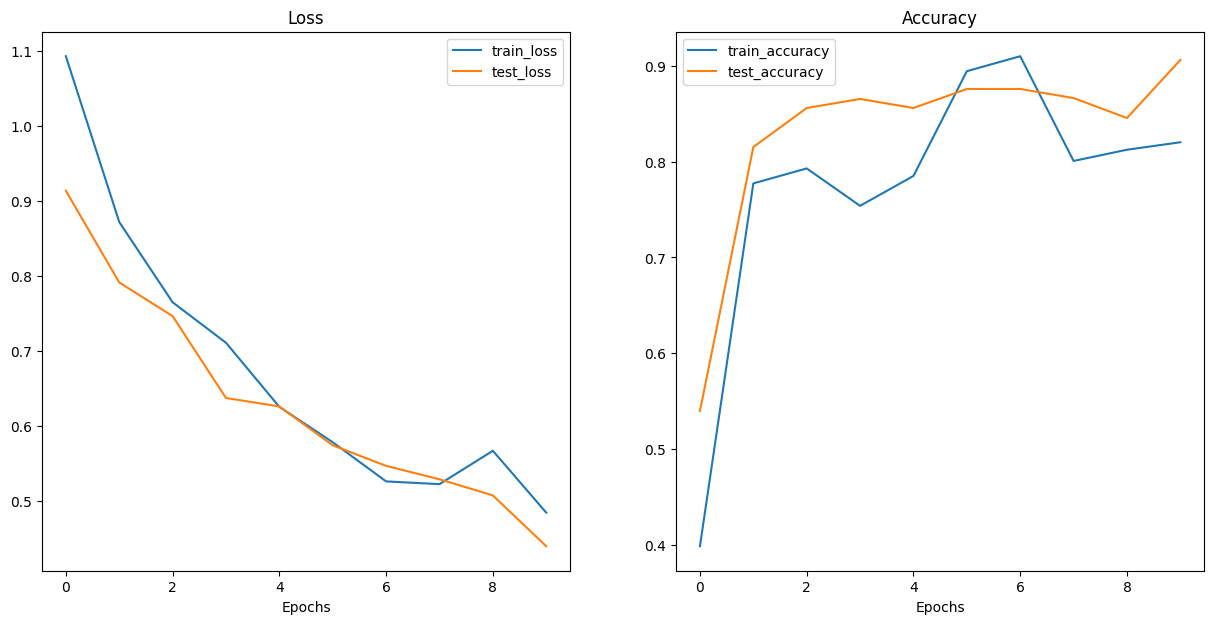

In [21]:
import requests

# Download helper functions from the course repo
try:
    from helper_functions import plot_loss_curves
    print("helper_functions.py already exists, skipping download.")
except:
    print("Couldn't find helper_functions.py, downloading it...")
    with open("helper_functions.py", "wb") as f:
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)


# Plot the loss curves
from helper_functions import plot_loss_curves
plot_loss_curves(results)

In [22]:
results.directory()

AttributeError: 'dict' object has no attribute 'directory'

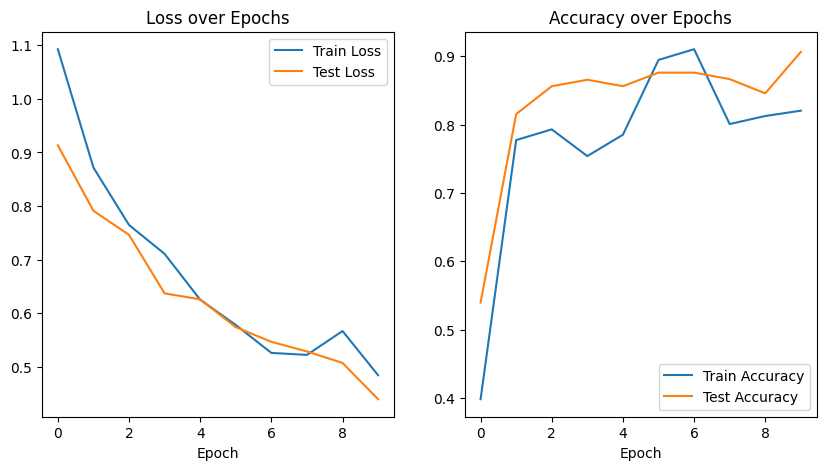

In [23]:
# Plotting the training curve
import matplotlib.pyplot as plt

def plot_results(results_dict):
    plt.figure(figsize=(10, 5))
    epochs = range(len(results_dict["train_loss"]))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, results_dict["train_loss"], label="Train Loss")
    plt.plot(epochs, results_dict["test_loss"], label="Test Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, results_dict["train_acc"], label="Train Accuracy")
    plt.plot(epochs, results_dict["test_acc"], label="Test Accuracy")
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

plot_results(results)


## 6. Make predictions on images from the test set

Some things to keeep in mind while making predictions /interference on test data:
1. Same shape - images need to be same shape as model was trained on
2. Same datatype - custom data should be in same datatype
3. Same device - custom data should be in same device as model
4. Same transform - If you've transformed your custom data, ideally you will transform the test data and custom data




To do all of this, we can make function ! that:
1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device
2. Open the image with 'PIL.Image.Open()'
3. Create a transform if one doesnt exist
4. Make sure the model is on the target device
5. Turn the model to 'model.eval' to make sure its ready for inference
6. Transform the target image and make sure its dimensionality is suited for the model (mainly relates to batch size)
7. Make a prediction on the image by passing to the model
8. Convert the models output logits to prediction probabilities using torch.softmax()
9. Convert models prediction porbabilities to prediction labels using torch.argmax()
10. Plot the image with matplotlib and set the title to the prediction label from step 9 and prediction probability from step 8

In [26]:
from typing import List, Tuple

from PIL import Image

from torchvision import transforms

# 1. Take in a trained model
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224,224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
  # 2. Open image with PIL
  img = Image.open(image_path)

  # 3. Create a transform if one doesnt exist
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229,0.224,0.225])
    ])

  ### Predict on image ###
  # 4. Make sure model is on target device
  model.to(device)

  # 5. Turn on inference mode
  model.eval()
  with torch.inference_mode():
    # 6. Transforms the image and add an extra baych dimension
    transformed_image = image_transform(img).unsqueeze(dim=0) # Batch size, color, height, width

    # 7. Make a prediction on the transformed image by passing it tot the model (make sure on target device)
    target_image_pred = model(transformed_image.to(device))

  # 8. Convert model output logits to pred probs
  target_image_pred_probs = torch.softmax(target_image_pred, dim = 1)

  # 9. Convert the model pred probs to pred labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim = 1)

  # 10. Plot the image with predicted label and prediction
  plt.figure()
  plt.imshow(img)
  # Get the prediction probability as a Python float
  pred_prob = target_image_pred_probs.max().item()
 # Get the prediction label as a Python int
  pred_label_index = target_image_pred_label.item()

 # Set the title with the correct values
  plt.title(f"Pred: {class_names[pred_label_index]} | Prob: {target_image_pred_probs.max():.3f}")
  plt.axis(False);

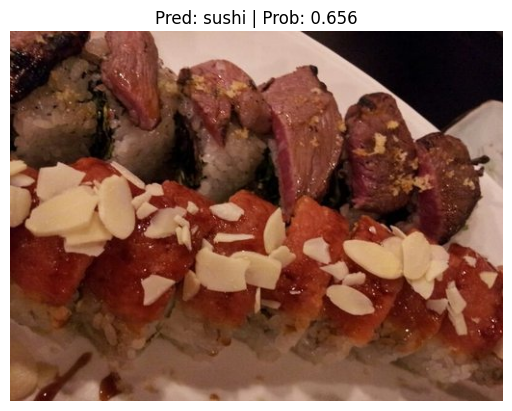

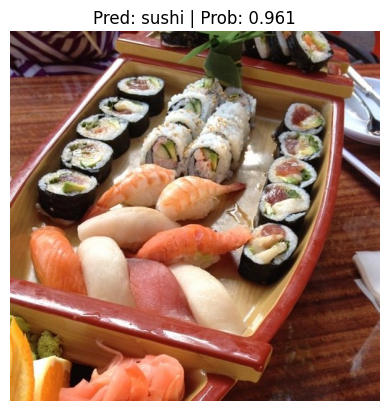

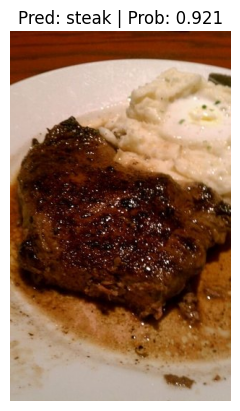

In [28]:
# Get a random list of image paths from the test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_list
test_image_path_sample = random.sample(population = test_image_path_list,
                                       k = num_images_to_plot)
test_image_path_sample
# Make predictions on and plot the images
for image_path in test_image_path_sample:
  pred_and_plot_image(model = model,
                      image_path = image_path,
                      class_names = class_names,
                      image_size=(224,224))

### 6.1 Make prediction on custom image

In [48]:
# Dwonload the image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn.t exit
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # Download image from github with raw link
    request = requests.get("https:///github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpg")
    print(f"Downloading")
    f.write(request.content)
else:
  print(f"It already exist")


It already exist


In [49]:
# Predict on custom image
pred_and_plot_image(model = model,
                    image_path = custom_image_path,
                    class_names=class_names)

UnidentifiedImageError: cannot identify image file 'data/04-pizza-dad.jpeg'